# Draft in rapidly adapting populations

## Setup

Import fwdpy11 and the bubble recorder (records the total lineage size of neutral mutations, or the "weight of the mutant bubble")

In [1]:
import numpy as np
import fwdpy11
import fwdpy11.model_params
import fwdpy11.fitness
import fwdpy11.wright_fisher

# plotting stuff
import matplotlib.pyplot as plt
import powerlaw as pl

# pybind11 C++ recorder
import cppimport
cppimport.set_quiet(False)
bubble_recorder = cppimport.imp("bubble_recorder")

Matching checksum for /Users/vancleve/science/projects/taylor_kessinger/draft_valley_crossing/fwdpy11/bubble_recorder.cpp --> not compiling


I will run a simulation with additive sites, exponentially distributed beneficial mutations, and uniform recombination (that we'll set very low to maximize draft). This is the simulation function.

In [2]:
def evolve_draft(ngens, N, s, mu, r, burn=500, seed=42, prune_selected=False):
    """
    Evolve drafting region and record bubble sizes
    """

    pop = fwdpy11.SlocusPop(N)
    rng = fwdpy11.GSLrng(seed)

    params = fwdpy11.model_params.SlocusParams(
        nregions=[fwdpy11.Region(0, 1, 1)],
        sregions=[fwdpy11.ExpS(0, 1, 1, s, 1.0)],
        recregions=[fwdpy11.Region(0, 1, 1)],
        gvalue=fwdpy11.fitness.SlocusAdditive(2.0),
        demography=np.array([N]*ngens, dtype=np.uint32),
        rates=(mu, mu, r),
        prune_selected=prune_selected
        )
    # recorder = BubbleRecorder()
    recorder = bubble_recorder.BubbleRecorder()

    fwdpy11.wright_fisher.evolve(rng, pop, params, recorder)

    return pop, np.array(list(recorder.weights.values()))

Plotting is done on a log-log scale. Typically, these power laws are hard to fit, so we use a package that does this nicely and produces good plots.

In [3]:
# plot using the 'powerlaw' package and show fit
def plot_weight_powerlaw(weights, fit=None, loc=3, N=None, s=None):
    if fit is None:
        fit = pl.Fit(weights, discrete=True)

    fit.plot_pdf(color='b', label='empirical: N = ' + str(N) + ', s = ' + str(np.round(s,2)))
    fit.power_law.plot_pdf(color='b', linestyle='--',
                           label=r'power law fit: $\alpha$ = ' + str(np.round(fit.alpha,3)))
    plt.legend(loc=3)

    return fit

## Analysis

Neher and Shraiman (2011, Genetics) show that rapidly adapting population experiencing draft have total lineage sizes ("weights") that fall off as $1/w^2$ (eqn 13 and Figure 6). This is in contrast to populations only experiencing drift where the total lineage sizes fall off as $1/w^{3/2}$.

While I can produce this "draft" result using `fwdpy11`, it depends on whether or not I prune the selected mutations. If I *do prune* them, I get the correct $w^2$ scaling:

CPU times: user 49.2 s, sys: 413 ms, total: 49.6 s
Wall time: 49.8 s


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/usr/local/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


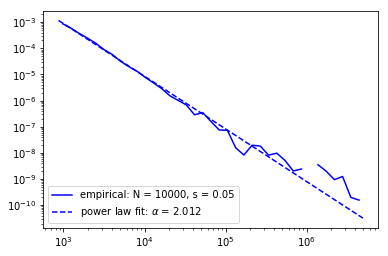

In [4]:
%time out = evolve_draft(20000, 10000, 0.05, 0.001, 0.0001, seed=314, prune_selected=True)
plot_weight_powerlaw(out[1], N=10000, s=0.05)

However, if I don't prune the selected mutations, I get the "drift" scaling, even though selection is very, very strong:

CPU times: user 1min 27s, sys: 639 ms, total: 1min 28s
Wall time: 1min 28s


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/usr/local/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


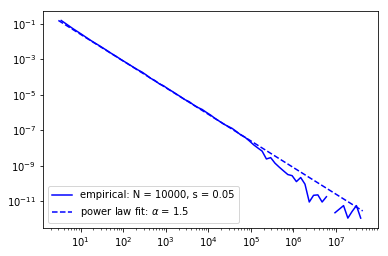

In [5]:
%time out = evolve_draft(20000, 10000, 0.05, 0.001, 0.0001, seed=314, prune_selected=False)
plot_weight_powerlaw(out[1], N=10000, s=0.05)

This is unexpected in part because of the two scenarios to produce anomalous results, I would have expected it to be the pruned case, since this should cause changes in the absolute fitness of gametes.